In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 
import xgboost as xgb

In [2]:
################################################################################################################################################
# Ensemble Regression 
################################################################################################################################################
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple, Any, Optional
from collections import defaultdict

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import KFold

# --------- utilities (reuse your helpers) ---------
def _pred_cols(df: pd.DataFrame) -> List[str]:
    return [c for c in df.columns if '_pred_' in c]

def _truth_col_for(pred_col: str) -> str:
    return pred_col.replace('_pred_', '_truth_')

def _safe_intersect_mask(dfs: List[pd.DataFrame], region_col: str, region_val) -> np.ndarray:
    mask = pd.Series(True, index=dfs[0].index)
    for df in dfs:
        mask &= (df[region_col] == region_val)
    return mask.values

def _build_Xy(
    dfs: List[pd.DataFrame],
    pred_col: str,
    truth_df: pd.DataFrame,
    mask: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    X_parts = []
    for df in dfs:
        X_parts.append(df.loc[mask, pred_col].to_numpy(dtype=float)[:, None])
    X = np.hstack(X_parts) if X_parts else np.empty((0, 0))
    tcol = _truth_col_for(pred_col)
    if tcol in truth_df.columns:
        y = truth_df.loc[mask, tcol].to_numpy(dtype=float)
    else:
        y = np.full(X.shape[0], np.nan)
    return X, y

# --------- learning: ridge by region (scikit-learn) ---------
def learn_ridge_by_region_sklearn(
    dfs_val: List[pd.DataFrame],
    region_col: str = 'NA_L1NAME',
    alphas: Optional[List[float]] = None,
    kfolds: int = 5,
    min_rows_per_region: int = 20,
    random_state: int = 42
) -> Dict[str, Dict[str, Dict[str, Any]]]:
    """
    Fits a ridge model per region and per *_pred_* column using scikit-learn RidgeCV.
    Returns:
        { region: { pred_col: {'w': np.ndarray (n_models,), 'b': float, 'alpha': float} } ,
          "__DEFAULT__": { ... } }
    """
    if alphas is None:
        alphas = [0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 3, 10]

    truth_df = dfs_val[0]
    pred_cols = _pred_cols(truth_df)

    # Regions present in ANY df
    regions = set()
    for df in dfs_val:
        regions |= set(df[region_col].dropna().unique())

    kf = KFold(n_splits=kfolds, shuffle=True, random_state=random_state)

    def _neutral(n_models: int):
        return {'w': np.full(n_models, 1.0 / max(n_models, 1)),
                'b': 0.0, 'alpha': np.nan}

    def _fit_all_cols(mask: np.ndarray) -> Dict[str, Dict[str, Any]]:
        out = {}
        for col in pred_cols:
            tcol = _truth_col_for(col)
            if tcol not in truth_df.columns:
                out[col] = _neutral(len(dfs_val))
                continue

            X, y = _build_Xy(dfs_val, col, truth_df, mask)
            # filter finite rows
            ok = np.isfinite(X).all(axis=1) & np.isfinite(y)
            if X.shape[1] == 0 or ok.sum() < min_rows_per_region:
                out[col] = _neutral(len(dfs_val))
                continue

            Xu, yu = X[ok], y[ok]

            # if too few rows for CV, do a single Ridge fit with a small alpha
            if Xu.shape[0] < max(4, kfolds):
                a = alphas[0] if len(alphas) else 0.0
                model = Ridge(alpha=a, fit_intercept=True)
                model.fit(Xu, yu)
                w = model.coef_.astype(float)
                b = float(model.intercept_)
                out[col] = {'w': w, 'b': b, 'alpha': float(a)}
                continue

            # CV over provided alphas; RidgeCV refits on all data with best alpha by default (store_cv_values=False)
            # Important: fit_intercept=True keeps intercept unpenalized in sklearn.
            cv = RidgeCV(alphas=alphas, store_cv_values=False, fit_intercept=True, cv=kf)
            try:
                cv.fit(Xu, yu)
                w = cv.coef_.astype(float)
                b = float(cv.intercept_)
                a_best = float(cv.alpha_)
                # sanity check
                if not np.isfinite(w).all() or not np.isfinite(b):
                    out[col] = _neutral(len(dfs_val))
                else:
                    out[col] = {'w': w, 'b': b, 'alpha': a_best}
            except Exception:
                out[col] = _neutral(len(dfs_val))

        return out

    # Global/default model
    global_mask = np.ones(len(truth_df), dtype=bool)
    global_models = _fit_all_cols(global_mask)

    models_by_region: Dict[str, Dict[str, Dict[str, Any]]] = {"__DEFAULT__": global_models}

    # Per-region models
    for r in regions:
        mask = _safe_intersect_mask(dfs_val, region_col, r)
        if int(mask.sum()) < min_rows_per_region:
            models_by_region[r] = global_models
            continue

        r_models = _fit_all_cols(mask)

        # If every col fell back (all alphas NaN), use global
        if all(np.isnan(m['alpha']) for m in r_models.values()):
            models_by_region[r] = global_models
        else:
            models_by_region[r] = r_models

    return models_by_region

# --------- applying (reuse your logic; only change function name) ---------
def apply_ridge_by_region_sklearn(
    dfs_test: List[pd.DataFrame],
    models_by_region: Dict[str, Dict[str, Dict[str, Any]]],
    region_col: str = 'NA_L1NAME'
) -> pd.DataFrame:
    df_out = dfs_test[0].copy()
    pred_cols = _pred_cols(df_out)
    default_models = models_by_region.get("__DEFAULT__", {})

    for r in df_out[region_col].dropna().unique():
        mask = _safe_intersect_mask(dfs_test, region_col, r)
        if mask.sum() == 0:
            continue
        region_models = models_by_region.get(r, default_models)

        for col in pred_cols:
            X_parts = [df.loc[mask, col].to_numpy(float)[:, None] for df in dfs_test]
            X = np.hstack(X_parts) if X_parts else np.empty((0, 0))

            model = region_models.get(col, default_models.get(col, None))
            if model is None:
                yhat = np.nanmean(X, axis=1) if X.size else np.array([])
            else:
                w = np.asarray(model['w'])
                b = float(model['b'])
                if X.shape[1] != w.shape[0] or X.size == 0 or not np.isfinite(w).all() or not np.isfinite(b):
                    yhat = np.nanmean(X, axis=1) if X.size else np.array([])
                else:
                    yhat = X @ w + b
            df_out.loc[mask, col] = yhat

    unmatched_mask = ~df_out[region_col].isin(models_by_region.keys()) | df_out[region_col].isna()
    if unmatched_mask.any():
        for col in pred_cols:
            X_parts = [df.loc[unmatched_mask, col].to_numpy(float)[:, None] for df in dfs_test]
            X = np.hstack(X_parts) if X_parts else np.empty((0, 0))
            model = default_models.get(col, None)
            if model is None:
                yhat = np.nanmean(X, axis=1) if X.size else np.array([])
            else:
                w = np.asarray(model['w']); b = float(model['b'])
                if X.shape[1] != w.shape[0] or X.size == 0 or not np.isfinite(w).all() or not np.isfinite(b):
                    yhat = np.nanmean(X, axis=1) if X.size else np.array([])
                else:
                    yhat = X @ w + b
            df_out.loc[unmatched_mask, col] = yhat

    return df_out

# --------- glue ---------
def ridge_ensemble_into_registry_sklearn(
    method_names: List[str],
    all_methods_final_val: Dict[str, pd.DataFrame],
    all_methods_final: Dict[str, pd.DataFrame],
    out_name: str,
    region_col: str = 'NA_L1NAME',
    alphas: Optional[List[float]] = None,
    kfolds: int = 5,
    min_rows_per_region: int = 20,
    random_state: int = 42
):
    dfs_val  = [all_methods_final_val[m] for m in method_names]
    dfs_test = [all_methods_final[m]     for m in method_names]

    models = learn_ridge_by_region_sklearn(
        dfs_val,
        region_col=region_col,
        alphas=alphas,
        kfolds=kfolds,
        min_rows_per_region=min_rows_per_region,
        random_state=random_state
    )
    df_out = apply_ridge_by_region_sklearn(dfs_test, models, region_col=region_col)
    all_methods_final[out_name] = df_out
    return models

In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_methods_regions(results_mae_map, methods = ["Transformer-LSP", "Prithvi-Pretraining", "Prithvi-Pretraining-Freeze"]):
    # === Load tile geometries ===
    geo_data = gpd.read_file("/projectnb/hlsfm/applications/lsp/ancillary/HP_LSP/geotiff_extents.geojson")
    geo_data = geo_data.rename(columns={"Site_ID": "SiteID"})
    geo_data["HLStile"] = "T" + geo_data["name"]
    geo_data = geo_data.set_crs("EPSG:4326").to_crs(epsg=3857)
    geo_data["centroid"] = geo_data.geometry.centroid

    # === Load ecoregion shapefile ===
    eco_path = "useco1/NA_CEC_Eco_Level1.shp"  # Update this path
    eco_gdf = gpd.read_file(eco_path).to_crs(geo_data.crs)  # project to match tile centroids

    mae_filtered = results_mae_map[results_mae_map["Method"].isin(methods)]


    # === Prepare GeoDataFrame of result centroids ===
    results_df = mae_filtered.copy()
    results_df = results_df[["HLStile", "SiteID", "Method", "MAE"]]
    results_df = results_df.merge(
        geo_data[["HLStile", "SiteID", "centroid"]],
        on=["HLStile", "SiteID"],
        how="left"
    )
    results_gdf = gpd.GeoDataFrame(results_df, geometry="centroid", crs=geo_data.crs)
    results_gdf = results_gdf.dropna(subset=["centroid"])  # drop unmatched rows

    # === Spatial join: assign each result to an ecoregion ===
    results_with_region = gpd.sjoin(results_gdf, eco_gdf, how="inner", predicate="intersects")

    # === Choose desired region level ===
    region_column = "NA_L1NAME"  # or US_L1NAME or US_L3NAME for more/fewer regions

    # === Group by region and method ===
    region_method_mae = (
        results_with_region.groupby([region_column, "Method"])["MAE"]
        .mean()
        .reset_index()
    )

    # === Plot grouped bar chart ===
    plt.figure(figsize=(14, 8))
    sns.barplot(
        data=region_method_mae,
        x="MAE",
        y=region_column,
        hue="Method",
        palette="Set2"
    )
    plt.title("Average MAE by Ecoregion and Method", fontsize=16)
    plt.ylabel("Average MAE")
    plt.xlabel("Ecoregion")
    plt.xticks(rotation=90)
    plt.legend(title="Method")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mae_improvement_by_region(
    results_mae_map,
    geo_path,
    eco_path,
    methods_to_compare,
    anchor_method,
    region_column="NA_L1NAME",
    figsize=(12, 8)
):
    import geopandas as gpd
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # === Load tile extent data ===
    geo_data = gpd.read_file(geo_path)
    geo_data = geo_data.rename(columns={"Site_ID": "SiteID"})
    geo_data["HLStile"] = "T" + geo_data["name"]
    geo_data = geo_data.set_crs("EPSG:4326").to_crs(epsg=3857)
    geo_data["centroid"] = geo_data.geometry.centroid

    # === Filter and pivot methods ===
    methods = methods_to_compare + [anchor_method]
    mae_filtered = results_mae_map[results_mae_map["Method"].isin(methods)]

    mae_pivot = (
        mae_filtered.groupby(["HLStile", "SiteID", "Method"])["MAE"]
        .mean()
        .unstack()
        .dropna(subset=[anchor_method])
    )

    # === Calculate improvement relative to anchor ===
    for method in methods_to_compare:
        mae_pivot[f"diff_{method}"] = mae_pivot[anchor_method] - mae_pivot[method] 

    # === Merge centroids ===
    mae_pivot = mae_pivot.reset_index()
    mae_pivot = mae_pivot.merge(
        geo_data[["HLStile", "SiteID", "centroid"]],
        on=["HLStile", "SiteID"],
        how="left"
    )
    gdf = gpd.GeoDataFrame(mae_pivot, geometry="centroid", crs=geo_data.crs)

    # === Load ecoregions ===
    eco_gdf = gpd.read_file(eco_path).to_crs(gdf.crs)
    gdf = gpd.sjoin(gdf, eco_gdf, how="left", predicate="intersects")

    # === Group by region and calculate mean improvements ===
    diff_cols = [f"diff_{m}" for m in methods_to_compare]
    region_summary = gdf.groupby(region_column)[diff_cols].mean().reset_index()

    # === Sort regions by average improvement across all methods ===
    region_summary["mean_diff"] = region_summary[diff_cols].mean(axis=1)
    region_summary = region_summary.sort_values("mean_diff", ascending=False)

    # === Melt for plotting ===
    melted = region_summary.melt(id_vars=[region_column, "mean_diff"],
                                 value_vars=diff_cols,
                                 var_name="Method",
                                 value_name="MAE_diff")
    melted["Method"] = melted["Method"].str.replace("diff_", "")

    # Set region as a categorical variable sorted by mean_diff
    melted[region_column] = pd.Categorical(
        melted[region_column],
        categories=region_summary[region_column],
        ordered=True
    )

    # === Plot ===
    plt.figure(figsize=figsize)
    sns.barplot(
        data=melted,
        x="MAE_diff",
        y=region_column,
        hue="Method",
        palette="Set2"
    )
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    plt.xlabel(f"MAE Difference vs '{anchor_method}' (positive = better, negative = worse)")
    plt.ylabel("Ecoregion")
    plt.title(f"Average MAE Difference by Region (vs {anchor_method})", fontsize=14)
    plt.tight_layout()
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.legend(title="Method", loc="lower right")
    plt.show()


import geopandas as gpd
import pandas as pd

def add_region_to_results(
    results_df: pd.DataFrame,
    geo_path: str,
    eco_path: str,
    region_column: str = "NA_L1NAME",
    tile_name_col: str = "name",   # column in geo_path used to form "HLStile" = "T" + name
    site_id_col_geo: str = "Site_ID",  # will be renamed to "SiteID"
    predicate: str = "within"      # "within" for point-in-polygon (centroids), or "intersects"
) -> pd.DataFrame:
    """
    Attach an ecoregion label to every row in `results_df` using spatial joins:
      1) Build tile centroids from the tile extent geojson/shapefile
      2) Spatially join centroids to ecoregion polygons
      3) Merge the matched region back to `results_df` by (HLStile, SiteID)

    Parameters
    ----------
    results_df : pd.DataFrame
        Must contain columns ["HLStile", "SiteID"].
    geo_path : str
        Path to the tile extent GeoJSON/Shapefile (e.g., the same used in your plotting code).
    eco_path : str
        Path to the ecoregion polygons (e.g., "useco1/NA_CEC_Eco_Level1.shp").
    region_column : str
        Column in the ecoregion dataset to use as the label (e.g., "NA_L1NAME", "US_L1NAME", etc.).
    tile_name_col : str
        Column in the tile extent data that holds the tile string without the leading 'T'.
    site_id_col_geo : str
        Site ID column name in the tile extent data; will be renamed to "SiteID".
    predicate : str
        Spatial join predicate; defaults to "within" for point-in-polygon on centroids.

    Returns
    -------
    pd.DataFrame
        A copy of `results_df` with a new column `<region_column>` containing the region label (or NaN if unmatched).
    """
    # --- Load tile geometries and prepare centroids ---
    geo_gdf = gpd.read_file(geo_path).copy()
    if site_id_col_geo in geo_gdf.columns and "SiteID" not in geo_gdf.columns:
        geo_gdf = geo_gdf.rename(columns={site_id_col_geo: "SiteID"})
    if "HLStile" not in geo_gdf.columns:
        if tile_name_col not in geo_gdf.columns:
            raise ValueError(f"'{tile_name_col}' not found in tile file; provide the correct 'tile_name_col'.")
        geo_gdf["HLStile"] = "T" + geo_gdf[tile_name_col].astype(str)

    # ensure geographic CRS then project to a metric CRS for robust centroid calculation
    geo_gdf = geo_gdf.set_crs("EPSG:4326", allow_override=True).to_crs(3857)
    geo_gdf["geometry"] = geo_gdf.geometry  # ensure active geometry
    geo_gdf["centroid"] = geo_gdf.geometry.centroid

    centroids = gpd.GeoDataFrame(
        geo_gdf[["HLStile", "SiteID"]].copy(),
        geometry=geo_gdf["centroid"],
        crs=geo_gdf.crs
    ).drop_duplicates(subset=["HLStile", "SiteID"])

    # --- Load ecoregions and project to match ---
    eco_gdf = gpd.read_file(eco_path).to_crs(centroids.crs)
    if region_column not in eco_gdf.columns:
        raise ValueError(f"'{region_column}' not found in ecoregion data. Available columns: {list(eco_gdf.columns)}")

    # --- Spatial join (point-in-polygon for centroids) ---
    joined = gpd.sjoin(centroids, eco_gdf[[region_column, "geometry"]], how="left", predicate=predicate)
    joined = joined[["HLStile", "SiteID", region_column]].drop_duplicates()

    # --- Merge region back to the original results ---
    out = results_df.copy()
    out = out.merge(joined, on=["HLStile", "SiteID"], how="left")

    return out

In [4]:
def get_diff(lsp_data, our_data): 
    cols_prefix_to_check = ["D_truth_DOY", "G_truth_DOY", "M_truth_DOY", "S_truth_DOY"]
    for col in cols_prefix_to_check: 
        offset = np.mean(lsp_data[col] - (our_data[col]))
        for col2 in our_data.columns: 
            prefix = col.split("_")[0] + "_"
            if col2.startswith(prefix):
                our_data[col2] += offset

    return our_data

def check_correctness(lsp_data, our_data): 
    cols_prefix_to_check = ["D_truth_DOY", "G_truth_DOY", "M_truth_DOY", "S_truth_DOY"]
    for col in cols_prefix_to_check: 
        diff = np.abs(lsp_data[col] - our_data[col])
        diff = diff.dropna()
        diff = np.mean(diff)
        print(f"Mean difference for {col}: {diff:.4f}")
        assert diff < 2


def sort_df(df):
    return df.sort_values(by=['years', 'HLStile', 'SiteID', 'row', 'col', 'version']).reset_index(drop=True)

import os 
all_methods = {}
for results_file in os.listdir("results"):
    if "best_param" in results_file:
        continue
    df = pd.read_csv(f"results/{results_file}")
    all_methods[results_file[:-4]] = df

for key in all_methods.keys(): 
    all_methods[key] = sort_df(all_methods[key])
    
# for key in all_methods.keys(): 
#     if key == "Transformer-LSP_test": 
#         continue
#     all_methods[key] = get_diff(all_methods["Transformer-LSP_test"], all_methods[key])
#     check_correctness(all_methods["Transformer-LSP_test"], all_methods[key])


all_methods_val = {} 
for results_file in os.listdir("results_train/"):
    df_train = pd.read_csv(f"results_train/{results_file}")
    # df_val = pd.read_csv(f"results_val/{results_file}")
    all_methods_val[results_file[:-4]] = df_train


for key in all_methods_val.keys(): 
    all_methods_val[key] = sort_df(all_methods_val[key])


################################################################################################
# Setting up methods' clean names
################################################################################################

methods_to_clean = { 
    "Transformer-LSP_test": "Transformer-LSP, 1.0, (LSP Data)",
}

for percent in [0.0, 0.05, 0.2, 0.4, 0.6, 0.8, 1.0]: 
    for region in ["all"]:
        for split in ["test", "train"]: 
            methods_to_clean[f"freeze-False_loadcheckpoint-True_fullsize_sigmoid_region-{region}_{percent}_{split}"] = f"Prithvi-Pretraining (Our Data),{percent},{region}"
            methods_to_clean[f"freeze-False_loadcheckpoint-False_fullsize_sigmoid_region-{region}_{percent}_{split}"] = f"Prithvi-Random (Our Data),{percent},{region}"

            methods_to_clean[f"unet_lsp_fullsize_region-{region}_{percent}_{split}"] = f"3D UNet (Our Data),{percent},{region}"
            methods_to_clean[f"transformer_lsp_fullsize_spatial_region-{region}_{percent}_{split}"] = f"Mini Prithvi (Our Data),{percent},{region}"
            
            methods_to_clean[f"transformer_lsp_fullsize_pixels_{region}_{percent}_{split}"] = f"1D Shallow Transformer (Our Data),{percent},{region}"
            methods_to_clean[f"mlp_lsp_fullsize_pixels_{region}_{percent}_{split}"] = f"1D Shallow MLP (Our Data),{percent},{region}"

            methods_to_clean[f"qtransformer_lsp_fullsize_pixels_{region}_{percent}_{split}"] = f"1D Shallow QTransformer (Our Data),{percent},{region}"

            methods_to_clean[f"transformer_lsp_fullsize_pixelsimage_{region}_{percent}_{split}"] = f"1D Shallow Transformer Full image (Our Data),{percent},{region}"
            methods_to_clean[f"freeze-False_loadcheckpoint-True_fullsize_sigmoidtemp_region-{region}_{percent}_{split}"] = f"Prithvi-Pretraining Temp (Our Data),{percent},{region}"

            methods_to_clean[f"freeze-False_loadcheckpoint-True_fullsize_sigmoid_sampler_region-{region}_{percent}_{split}"] = f"Prithvi-Pretraining Sampler (Our Data),{percent},{region}"

            for patch_size in [2, 4, 8, 16, 32]:
                methods_to_clean[f"transformer_lsp_fullsize_patch{patch_size}_{region}_{percent}_{split}"] =  f"1D Shallow Transformer (Our Data),{percent},{region}, Patch-{patch_size}"

            #add lora 
            methods_to_clean[f"loadcheckpoint-True_fullsize_sigmoid_lora_region-{region}_{percent}_{split}"] = f"Prithvi-Pretraining Lora (Our Data),{percent},{region}"

            #add temporal only
            methods_to_clean[f"freeze-False_loadcheckpoint-True_fullsize_sigmoid_temporalonly_region-{region}_{percent}_{split}"] = f"Prithvi-Pretraining Temporal Only (Our Data),{percent},{region}"
            methods_to_clean[f"freeze-False_loadcheckpoint-False_fullsize_sigmoid_temporalonly_region-{region}_{percent}_{split}"] = f"Prithvi-Random Temporal Only (Our Data),{percent},{region}"

################################################################################################

all_methods_final = {}
for key in all_methods.keys(): 
    all_methods_final[methods_to_clean[key]] = all_methods[key]

all_methods_final_val = {}
for key in all_methods_val.keys(): 
    all_methods_final_val[methods_to_clean[key]] = all_methods_val[key]

all_methods_final = {}
for key in all_methods.keys(): 
    all_methods_final[methods_to_clean[key]] = add_region_to_results(
        results_df=all_methods[key],
        geo_path="/projectnb/hlsfm/applications/lsp/ancillary/HP_LSP/geotiff_extents.geojson",
        eco_path="useco1/NA_CEC_Eco_Level1.shp",
        region_column="NA_L1NAME"  # or "US_L1NAME"/"US_L3NAME"
    )

all_methods_final_val = {}
for key in all_methods_val.keys(): 
    all_methods_final_val[methods_to_clean[key]] = add_region_to_results(
        results_df=all_methods_val[key],
        geo_path="/projectnb/hlsfm/applications/lsp/ancillary/HP_LSP/geotiff_extents.geojson",
        eco_path="useco1/NA_CEC_Eco_Level1.shp",
        region_column="NA_L1NAME"  # or "US_L1NAME"/"US_L3NAME"
    )


In [5]:
for m1, m2 in [("Prithvi-Pretraining (Our Data),1.0,all", "1D Shallow Transformer (Our Data),1.0,all"), ("Prithvi-Pretraining Lora (Our Data),1.0,all", "1D Shallow Transformer (Our Data),1.0,all")]:
    # You can also add more base models here (m3, m4, ...) — it generalizes beyond two.
    base_methods = [m1, m2]

    # Train on VAL with CV, then apply to TEST and store
    out_key = f"Ensemble {', '.join(base_methods)}"
    models_dbg = ridge_ensemble_into_registry_sklearn(
        base_methods,
        all_methods_final_val,
        all_methods_final,
        out_name=out_key,
        region_col='NA_L1NAME',
        # optional knobs:
        alphas=[0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 3, 10],
        kfolds=5,
        min_rows_per_region=25
    )

# If you want to peek at per-region, per-column selected alphas:
# print(models_dbg['__DEFAULT__'][some_pred_col]['alpha'])


/projectnb/ivc-ml/mqraitem/.conda/envs/geo/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/projectnb/ivc-ml/mqraitem/.conda/envs/geo/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/projectnb/ivc-ml/mqraitem/.conda/envs/geo/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/projectnb/ivc-ml/mqraitem/.conda/envs/geo/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/project

In [6]:
def get_mae(df, tile, siteid, results, method):
    df_tile = df[(df["HLStile"] == tile) & (df["SiteID"] == siteid)]
    for date in ["G", "M", "S", "D"]: 
        mae = np.mean(np.abs(df_tile[f"{date}_pred_DOY"] - df_tile[f"{date}_truth_DOY"]))
        results["HLStile"].append(tile)
        results["Date"].append(date)
        results["MAE"].append(mae)
        results["SiteID"].append(siteid)
        results["Method"].append(method)
    return results 


def print_avg_results(methods):
    for method in methods:
        print(f"Average MAE for {method}:")
        for date in ["G", "M", "S", "D"]:
            avg_mae = results_mae[(results_mae["Method"] == method) & (results_mae["Date"] == date)]["MAE"].mean()
            print(f"  {date}: {avg_mae:.1f}")
        overall_avg = results_mae[results_mae["Method"] == method]["MAE"].mean()
        print(f"  Overall: {overall_avg:.1f}\n")
        print("" + "="*40 + "\n")


def organize_percent_results(methods):
    avg_results = {
        "Method": [],
        "MAE": [], 
        "% of Dataset": []
    }
    for method in methods:
        for date in ["G", "M", "S", "D"]:
            avg_mae = results_mae[(results_mae["Method"] == method) & (results_mae["Date"] == date)]["MAE"].mean()
        overall_avg = results_mae[results_mae["Method"] == method]["MAE"].mean()
        
        split_method = method.split(",") 
        percent = split_method[1]

        avg_results["Method"].append(split_method[0])
        avg_results["MAE"].append(float(overall_avg))
        avg_results["% of Dataset"].append(float(percent))

    return avg_results


def organize_patch_results(methods):
    patch_results = {
        "Patch Size": [],
        "MAE": [],
    }

    for method in methods:
        # f"1D Shallow Transformer (Our Data),{percent},{region}, Patch-{patch_size}"
        patch_size = method.split(",")[3].split("-")[1]
        patch_results["Patch Size"].append(patch_size)
        patch_results["MAE"].append(results_mae[results_mae["Method"] == method]["MAE"].mean())

    return pd.DataFrame(patch_results)

results = {"HLStile": [], "Date": [], "MAE": [], "Method": [], "SiteID": []}

#unique combos of HLStile and SiteID
for tile, siteid in all_methods_final["Prithvi-Pretraining (Our Data),0.2,all"][["HLStile", "SiteID"]].drop_duplicates().values:
    for key in all_methods_final.keys(): 
        results = get_mae(all_methods_final[key], tile, siteid, results, key)


results_df = pd.DataFrame(results)
mean_results = results_df.groupby(["HLStile", "SiteID", "Method"]).agg({"MAE": "mean"}).reset_index()
mean_results["Date"] = "Mean"
results_mae = pd.concat([results_df, mean_results], ignore_index=True)

In [7]:
methods_to_print = [method for method in all_methods_final.keys() if "1.0" in method]
avg_results = print_avg_results(methods_to_print)

Average MAE for 1D Shallow Transformer (Our Data),1.0,all, Patch-8:
  G: 23.2
  M: 19.8
  S: 21.8
  D: 17.4
  Overall: 20.5


Average MAE for Prithvi-Pretraining (Our Data),1.0,all:
  G: 16.7
  M: 15.2
  S: 20.5
  D: 18.5
  Overall: 17.7


Average MAE for 3D UNet (Our Data),1.0,all:
  G: 21.4
  M: 17.6
  S: 20.5
  D: 16.4
  Overall: 19.0


Average MAE for Prithvi-Random Temporal Only (Our Data),1.0,all:
  G: 24.7
  M: 22.0
  S: 23.4
  D: 21.7
  Overall: 23.0


Average MAE for 1D Shallow Transformer (Our Data),1.0,all, Patch-16:
  G: 22.9
  M: 19.7
  S: 22.4
  D: 18.6
  Overall: 20.9


Average MAE for Prithvi-Random (Our Data),1.0,all:
  G: 21.7
  M: 20.4
  S: 24.9
  D: 24.7
  Overall: 22.9


Average MAE for Mini Prithvi (Our Data),1.0,all:
  G: 21.3
  M: 19.1
  S: 21.8
  D: 19.3
  Overall: 20.4


Average MAE for 1D Shallow Transformer (Our Data),1.0,all, Patch-2:
  G: 16.1
  M: 13.7
  S: 18.2
  D: 15.1
  Overall: 15.8


Average MAE for 1D Shallow Transformer (Our Data),1.0,all, Patch-3

                               Method        MAE  % of Dataset
0      Prithvi-Pretraining (Our Data)  27.556414          0.05
1   1D Shallow Transformer (Our Data)  23.822187          0.05
2      Prithvi-Pretraining (Our Data)  27.487276          0.20
3   1D Shallow Transformer (Our Data)  19.696048          0.20
4      Prithvi-Pretraining (Our Data)  22.075185          0.40
5   1D Shallow Transformer (Our Data)  18.734609          0.40
6      Prithvi-Pretraining (Our Data)  18.958622          0.60
7   1D Shallow Transformer (Our Data)  15.574502          0.60
8      Prithvi-Pretraining (Our Data)  18.313762          0.80
9   1D Shallow Transformer (Our Data)  14.935774          0.80
10     Prithvi-Pretraining (Our Data)  17.719720          1.00
11  1D Shallow Transformer (Our Data)  15.388693          1.00


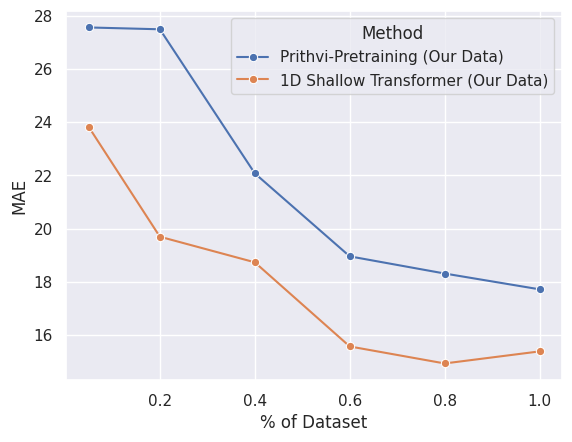

In [14]:
methods = [] 


for percent in [0.05, 0.2, 0.4, 0.6, 0.8, 1.0]: 
    for region in ["all"]:
        method_2 = f"1D Shallow Transformer (Our Data),{percent},{region}"
        method_1 = f"Prithvi-Pretraining (Our Data),{percent},{region}"
        methods.append(method_1)
        methods.append(method_2)
        # methods.append(f"1D Shallow QTransformer (Our Data),{percent},{region}")
        # methods.append(f"Ensemble {method_1} + {method_2}")
        # methods.append(f"Ensemble Weighted Region {method_1} + {method_2}")

avg_results = organize_percent_results(methods)
avg_results = pd.DataFrame(avg_results)

print(avg_results)
sns.lineplot(x="% of Dataset", y="MAE", data=avg_results, hue="Method", marker="o")
plt.show()


<Axes: xlabel='Patch Size', ylabel='MAE'>

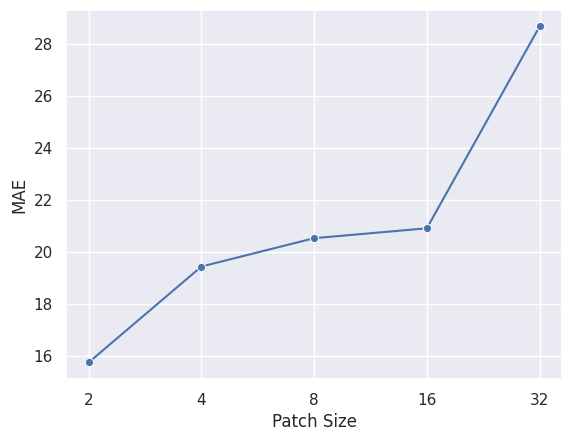

In [16]:
methods = [] 

for patch_size in [2, 4, 8, 16, 32]:
    method = f"1D Shallow Transformer (Our Data),1.0,all, Patch-{patch_size}"
    methods.append(method)

avg_results = organize_patch_results(methods)
avg_results = pd.DataFrame(avg_results)

sns.lineplot(x="Patch Size", y="MAE", data=avg_results, marker="o")

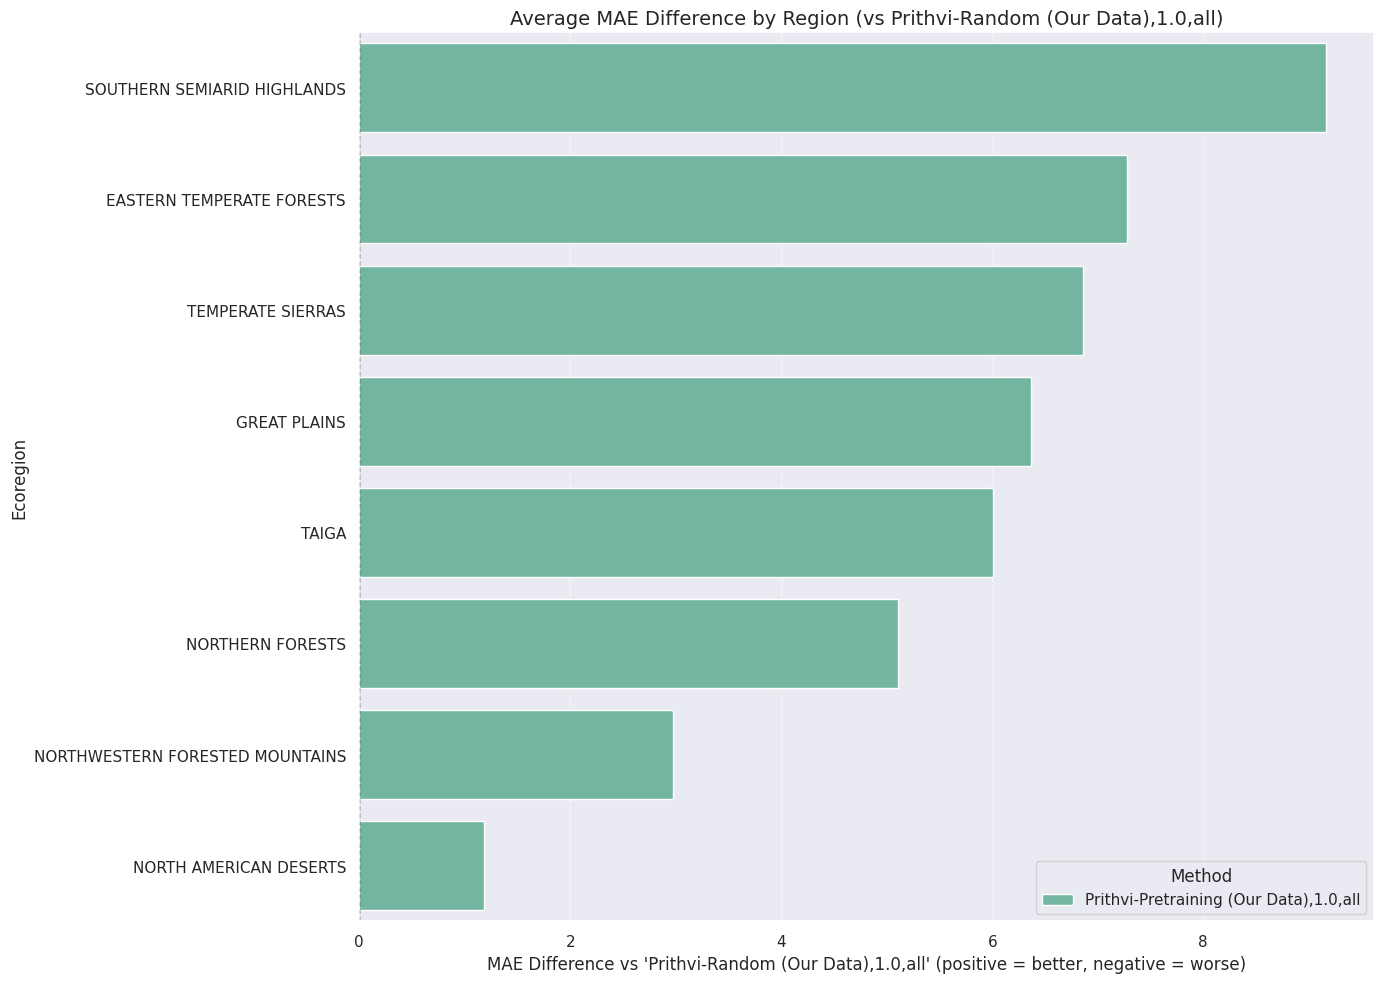

In [6]:
results_mae_map = results_mae.copy()
plot_mae_improvement_by_region(
    results_mae_map,
    geo_path="/projectnb/hlsfm/applications/lsp/ancillary/HP_LSP/geotiff_extents.geojson",
    eco_path="useco1/NA_CEC_Eco_Level1.shp",
    methods_to_compare=["Prithvi-Pretraining (Our Data),1.0,all"],
    anchor_method="Prithvi-Random (Our Data),1.0,all",
    figsize=(14, 10)
)

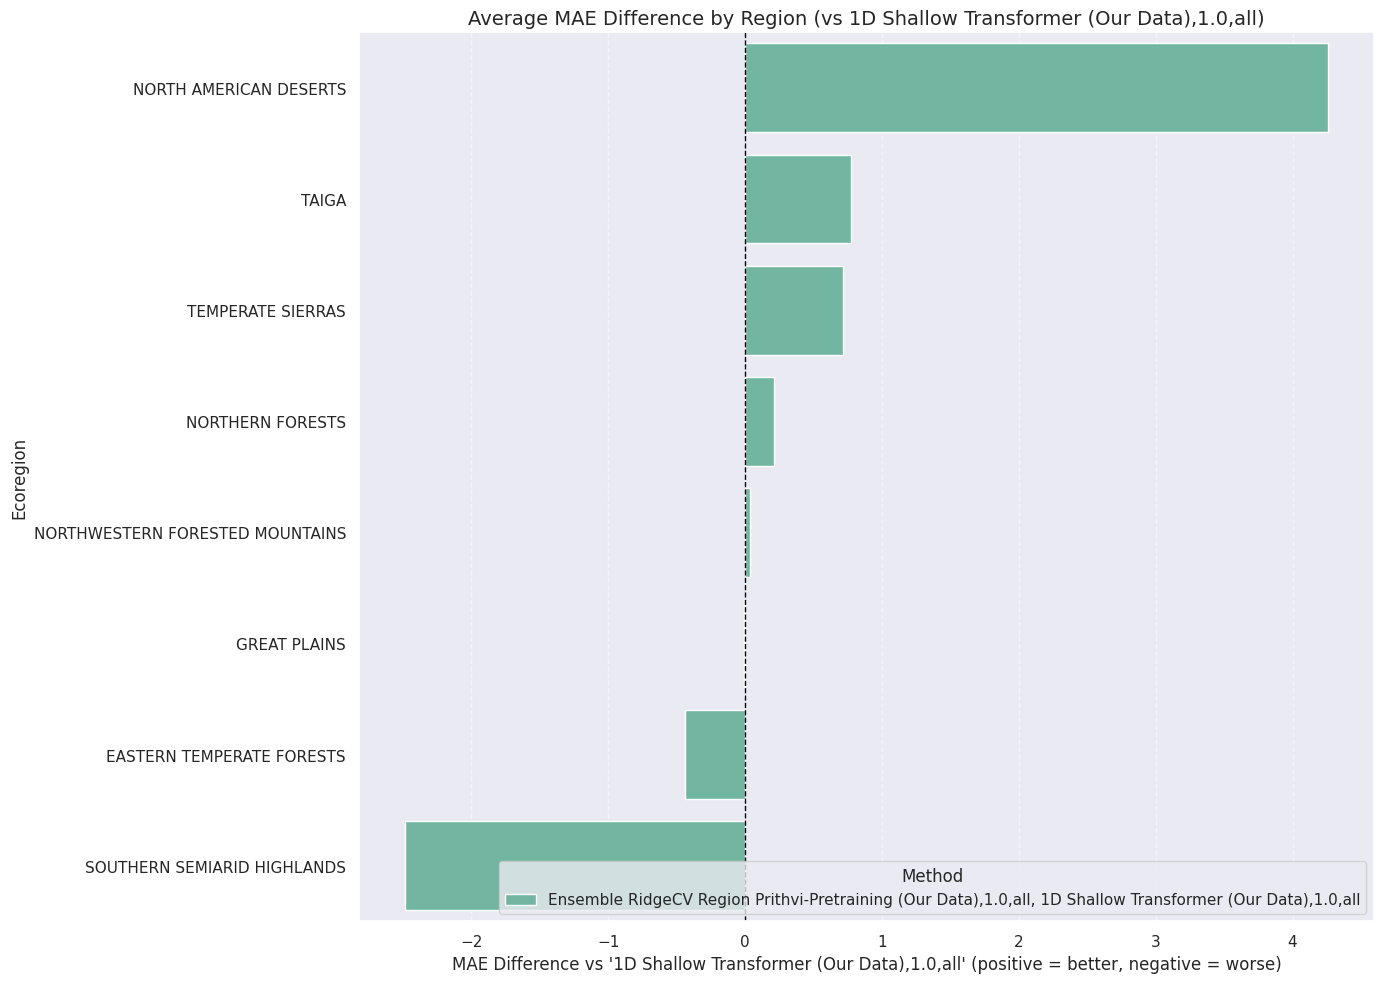

In [18]:
results_mae_map = results_mae.copy()
plot_mae_improvement_by_region(
    results_mae_map,
    geo_path="/projectnb/hlsfm/applications/lsp/ancillary/HP_LSP/geotiff_extents.geojson",
    eco_path="useco1/NA_CEC_Eco_Level1.shp",
    methods_to_compare=["Ensemble RidgeCV Region Prithvi-Pretraining (Our Data),1.0,all, 1D Shallow Transformer (Our Data),1.0,all"],
    anchor_method="1D Shallow Transformer (Our Data),1.0,all",
    figsize=(14, 10)
)

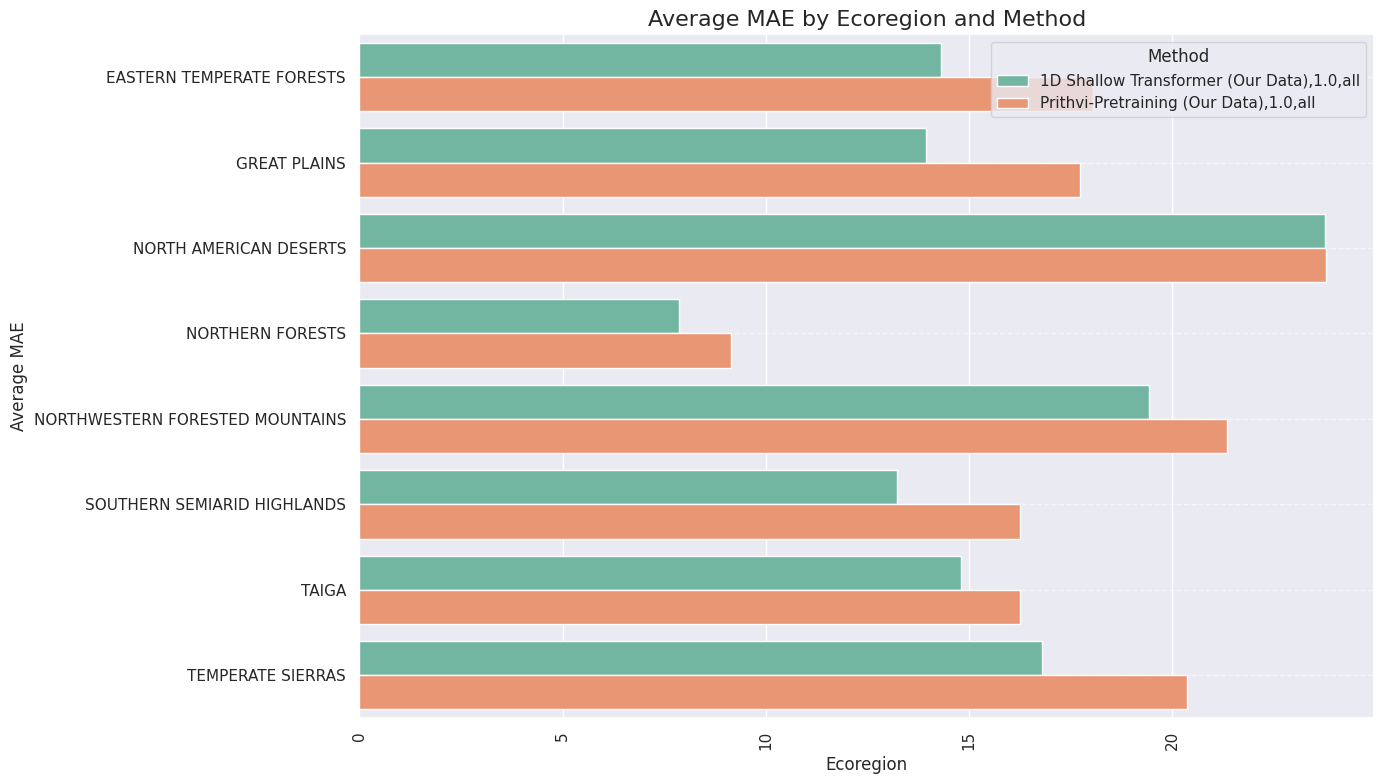

In [8]:
results_mae_map = results_mae.copy()
plot_methods_regions(results_mae_map, methods=["1D Shallow Transformer (Our Data),1.0,all", "Prithvi-Pretraining (Our Data),1.0,all"])

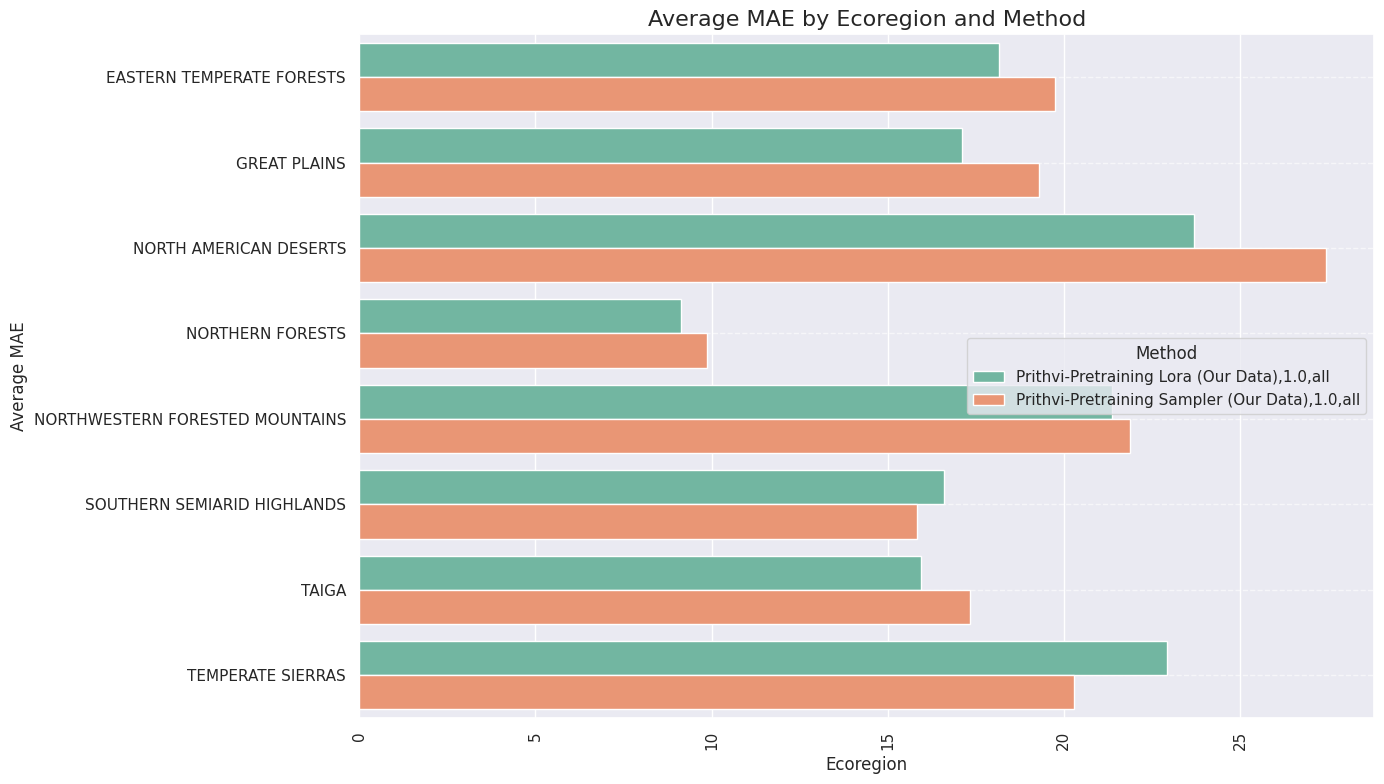

In [22]:
results_mae_map = results_mae.copy()
#and sampler
plot_methods_regions(results_mae_map, methods=["Prithvi-Pretraining Lora (Our Data),1.0,all", "Prithvi-Pretraining Sampler (Our Data),1.0,all"])

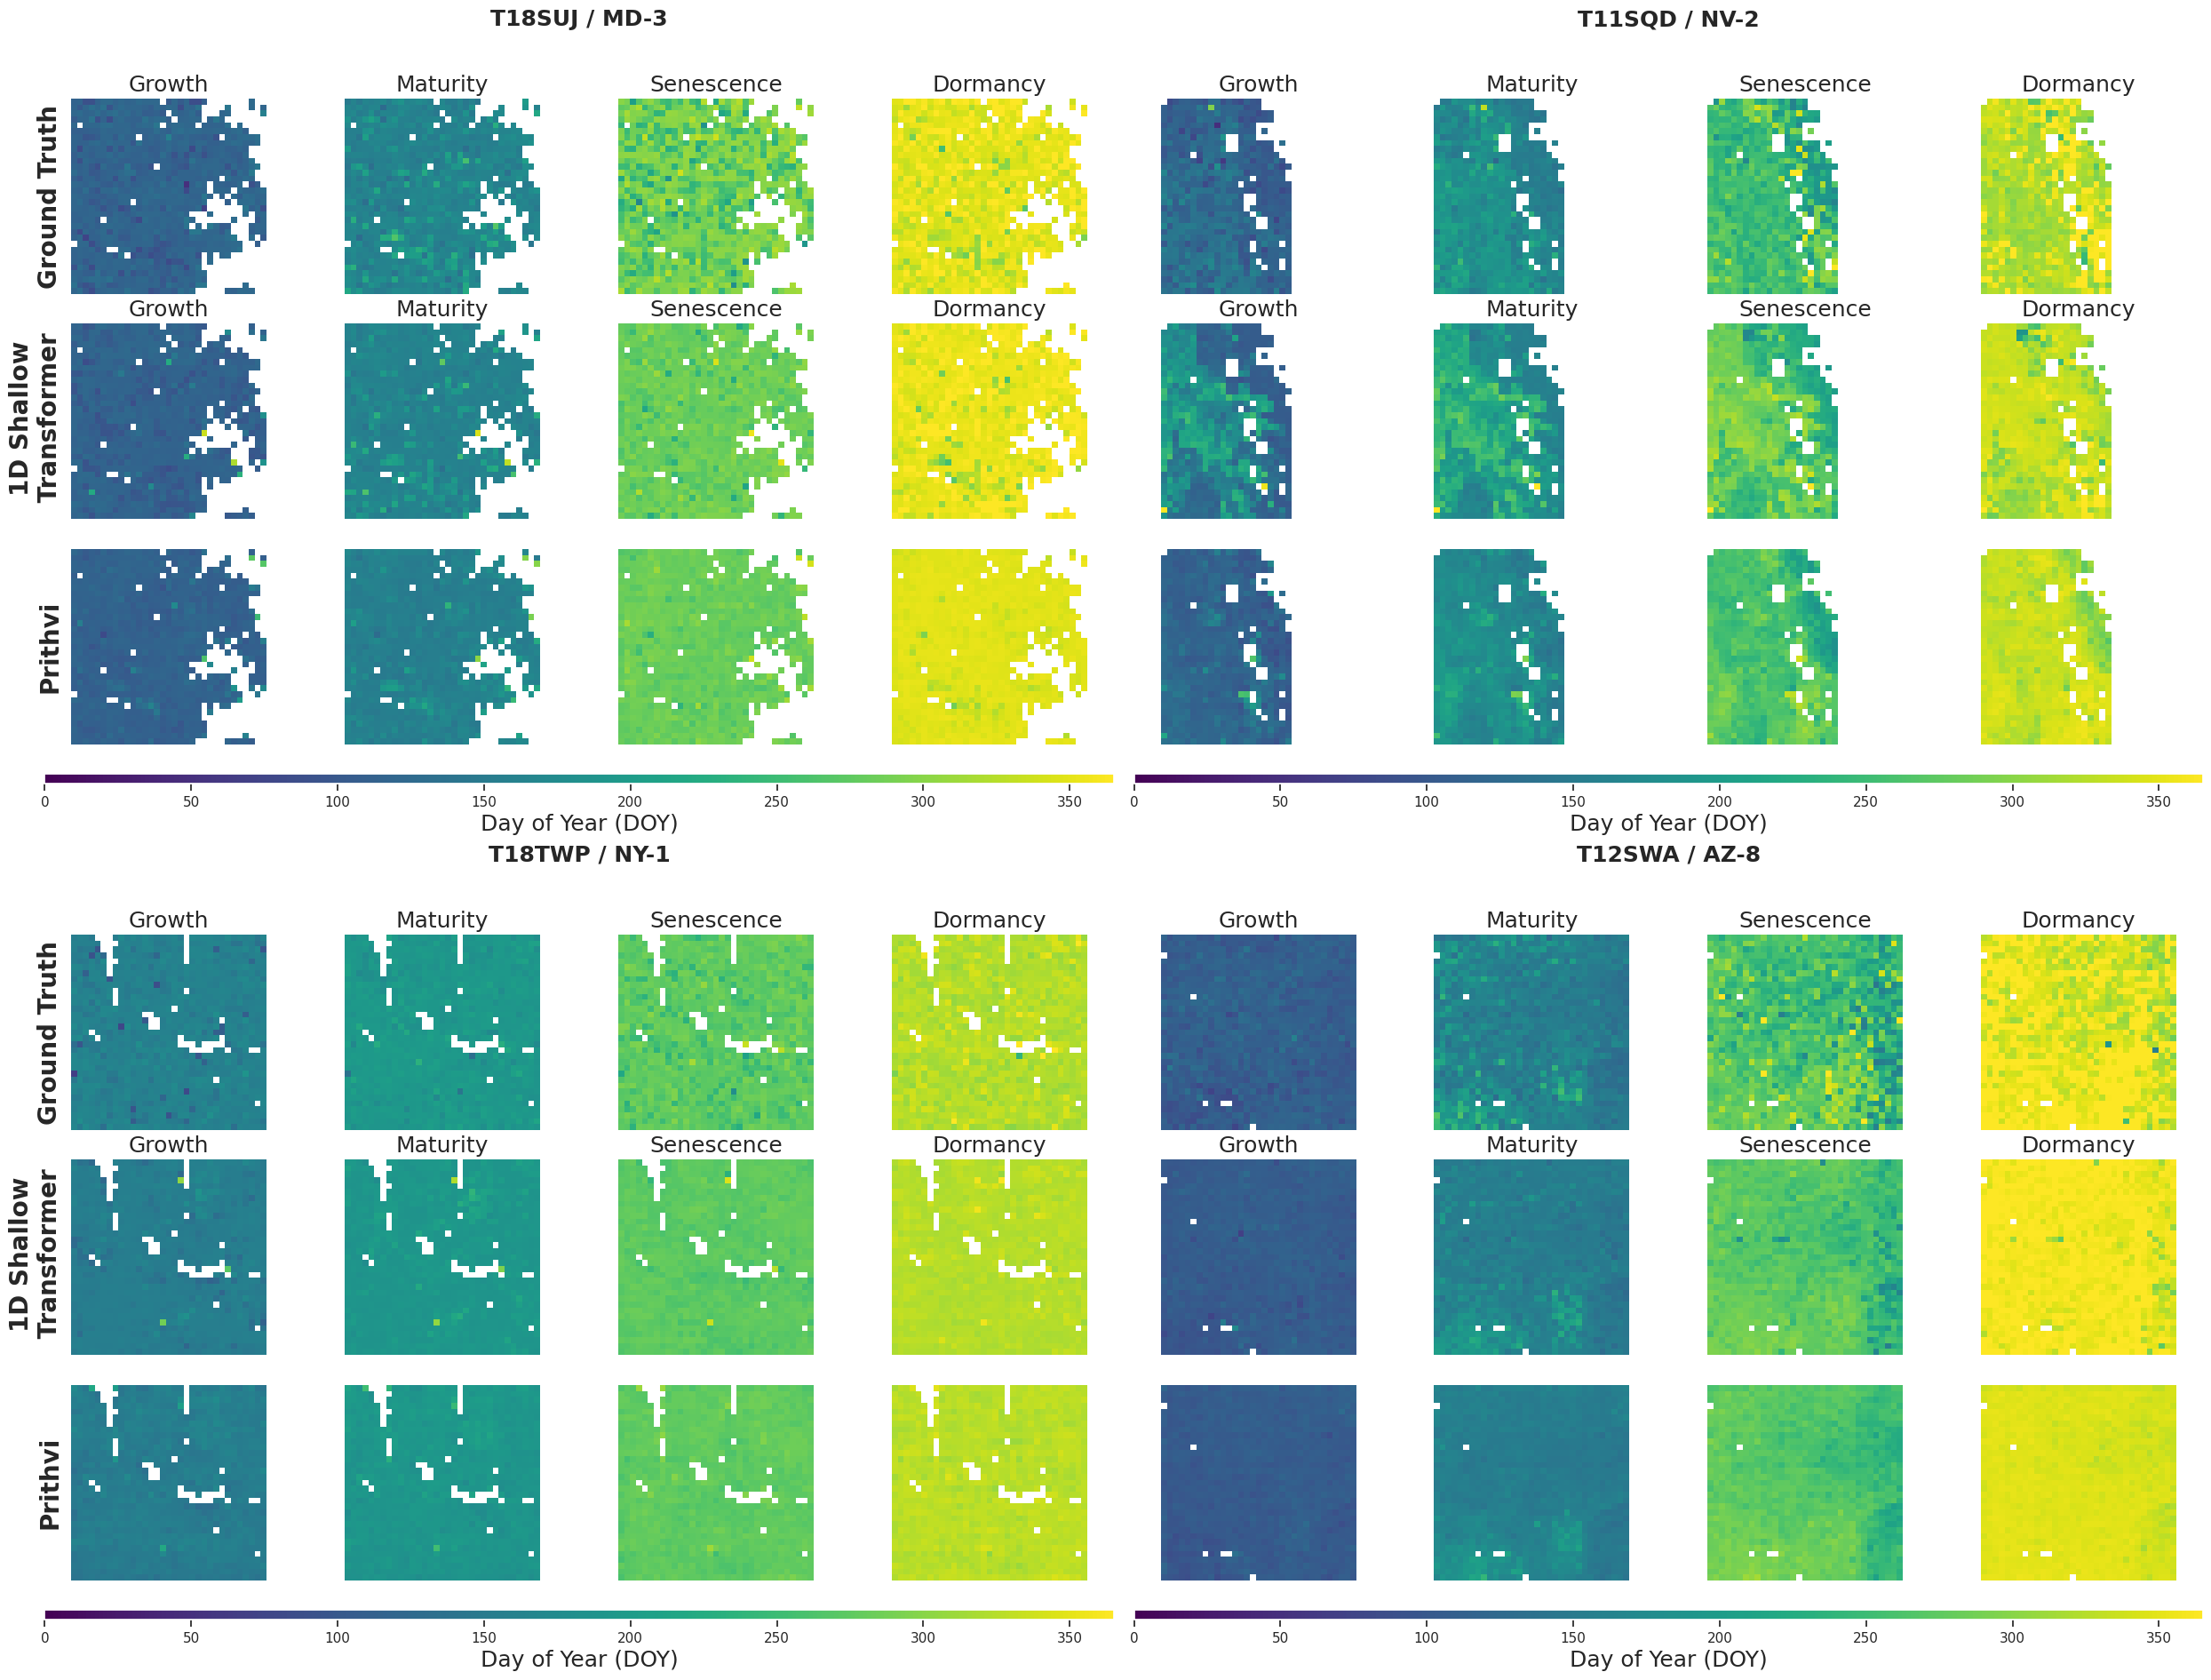

In [9]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

# ==== CONFIG ====
title_fontsize = 18
label_fontsize = 18
band_fontsize = 18
model_fontsize = 20
random_seed = 120
# ==== LOAD DATA ====
geo_data = gpd.read_file("/projectnb/hlsfm/applications/lsp/ancillary/HP_LSP/geotiff_extents.geojson")
geo_data["HLStile"] = "T" + geo_data["name"]
geo_data = geo_data.set_crs("EPSG:4326").to_crs(epsg=3857)
geo_data = geo_data.rename(columns={"Site_ID": "SiteID"})

prithvi_pretraining = all_methods_final["Prithvi-Pretraining (Our Data),1.0,all"]
transformer_lsp = all_methods_final["1D Shallow Transformer (Our Data),1.0,all"]

# ==== SAMPLE 4 RANDOM TILE-SITE COMBOS ====
pairs = prithvi_pretraining[["HLStile", "SiteID"]].drop_duplicates()
sampled_pairs = pairs.sample(n=4, random_state=random_seed).reset_index(drop=True)

# ==== HELPER ====
def reshape_doy(df, hlstile, siteid, band):
    subset = df[(df["HLStile"] == hlstile) & (df["SiteID"] == siteid)]
    image = np.full((33, 33), np.nan)
    for _, row in subset.iterrows():
        r = int(row["row"] // 10)
        c = int(row["col"] // 10)
        image[r, c] = row[f"{band}_pred_DOY"]
    return image

def reshape_doy_truth(df, hlstile, siteid, band):
    subset = df[(df["HLStile"] == hlstile) & (df["SiteID"] == siteid)]
    image = np.full((33, 33), np.nan)
    for _, row in subset.iterrows():
        r = int(row["row"] // 10)
        c = int(row["col"] // 10)
        image[r, c] = row[f"{band}_truth_DOY"]
    return image

# Expand band codes
band_labels = {
    "G": "Growth",
    "M": "Maturity",
    "S": "Senescence",
    "D": "Dormancy"
}

# ==== PLOTTING ====
fig, axs = plt.subplots(2, 2, figsize=(28, 20))

for idx, (hlstile, siteid) in sampled_pairs.iterrows():
    outer_row = idx // 2
    outer_col = idx % 2
    outer_ax = axs[outer_row, outer_col]

    # print(outer_col)

    # Create 2x4 subgrid inside each 2x2 tile panel
    from matplotlib.gridspec import GridSpecFromSubplotSpec
    gs_sub = GridSpecFromSubplotSpec(4, 4, subplot_spec=outer_ax.get_subplotspec(), 
                                    wspace=0.1, hspace=0.2, height_ratios=[1, 1, 1, 0.05])


    tile_geom = geo_data[(geo_data["HLStile"] == hlstile) & (geo_data["SiteID"] == siteid)]
    if tile_geom.empty:
        print(f"Skipping {hlstile}-{siteid} (no geometry)")
        continue

    # Draw model label once per row (left side)
    outer_ax.axis('off')
    outer_ax.text(0.5, 1.1, f"{hlstile} / {siteid}",
                  transform=outer_ax.transAxes, ha='center', va='bottom',
                  fontsize=title_fontsize, weight='bold')

    # === Loop over bands as before ===
    for i, band in enumerate(["G", "M", "S", "D"]):


        ax_g = fig.add_subplot(gs_sub[0, i])
        img_g = reshape_doy_truth(transformer_lsp, hlstile, siteid, band)
        im = ax_g.imshow(img_g, cmap="viridis", vmin=0, vmax=365)
        ax_g.set_title(band_labels[band], fontsize=band_fontsize)
        ax_g.axis('off')

        # Transformer row
        ax_t = fig.add_subplot(gs_sub[1, i])
        img_t = reshape_doy(transformer_lsp, hlstile, siteid, band)
        im = ax_t.imshow(img_t, cmap="viridis", vmin=0, vmax=365)
        ax_t.set_title(band_labels[band], fontsize=band_fontsize)
        ax_t.axis('off')

        # Prithvi row
        ax_p = fig.add_subplot(gs_sub[2, i])
        img_p = reshape_doy(prithvi_pretraining, hlstile, siteid, band)
        ax_p.imshow(img_p, cmap="viridis", vmin=0, vmax=365)
        ax_p.axis('off')

        if i == 0 and outer_col == 0:
            
            ax_g.text(-2, img_g.shape[0] // 2, "Ground Truth", fontsize=model_fontsize,
                    ha="right", va="center", rotation=90, transform=ax_g.transData, weight='bold')
            ax_t.text(-2, img_t.shape[0] // 2, "1D Shallow \n Transformer", fontsize=model_fontsize,
                    ha="right", va="center", rotation=90, transform=ax_t.transData, weight='bold')
            ax_p.text(-2, img_p.shape[0] // 2, "Prithvi", fontsize=model_fontsize,
                    ha="right", va="center", rotation=90, transform=ax_p.transData, weight='bold')

    # === Add per-grid colorbar (bottom row) ===
    cax_sub = fig.add_subplot(gs_sub[3, :])  # Bottom row, span all 4 columns
    cbar = fig.colorbar(im, cax=cax_sub, orientation="horizontal")
    cbar.set_label("Day of Year (DOY)", fontsize=label_fontsize)


plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


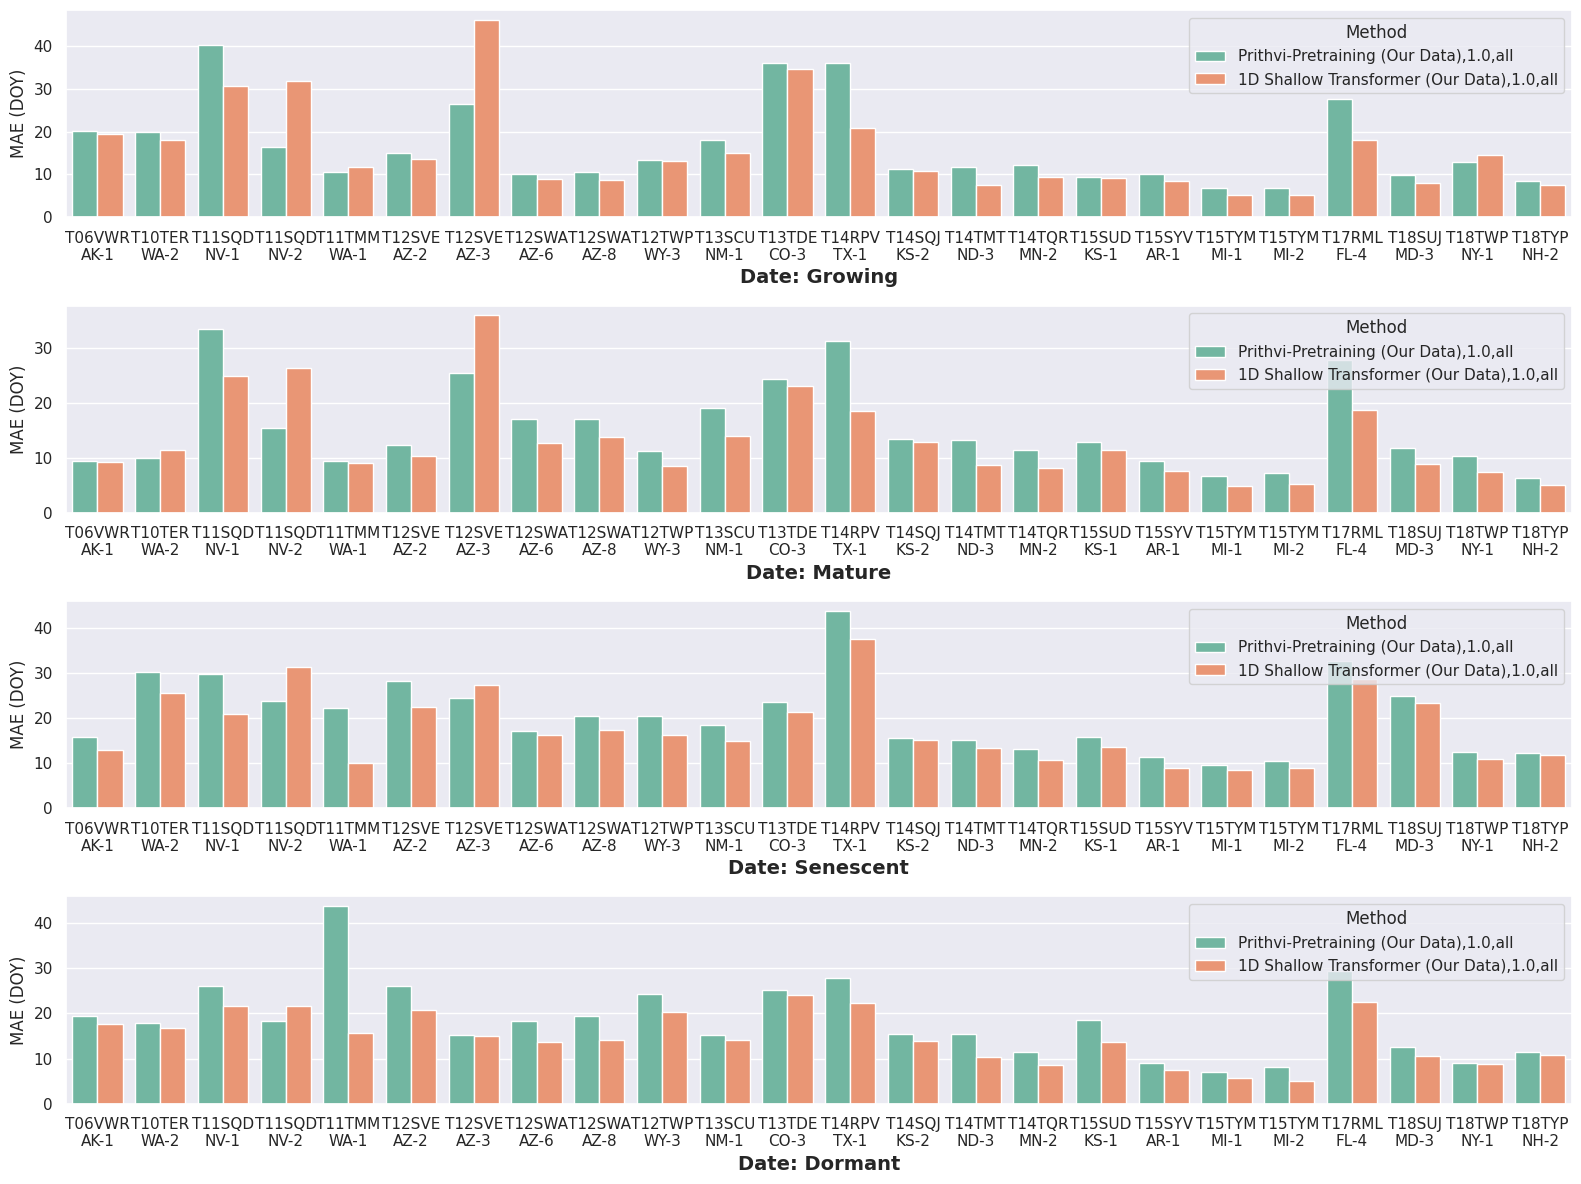

In [10]:
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


methods = ["Prithvi-Pretraining (Our Data),1.0,all", "1D Shallow Transformer (Our Data),1.0,all"]
results_mae_bar = results_mae[results_mae["Method"].isin(methods)].copy()

date_to_rename = {
    "G": "Growing",
    "M": "Mature",
    "S": "Senescent",
    "D": "Dormant",
    "Mean": "Mean"
}


#create a new column that combines HLStile and SiteID seperated by \n 
results_mae_bar["Hlstile_SiteID"] = results_mae_bar["HLStile"] + "\n" + results_mae_bar["SiteID"]


#fig with 4 subplots vertical 
fig, axs = plt.subplots(4, 1, figsize=(16, 12))
for idx, date in enumerate(["G", "M", "S", "D"]):
    results_plot_date = results_mae_bar[results_mae_bar["Date"] == date]
    sns.barplot(data=results_plot_date, x="Hlstile_SiteID", y="MAE", hue="Method", palette="Set2", ax=axs[idx])
    # axs[idx].set_title(f"MAE per HLStile for {date} by Method", fontsize=16)
    #make xlabel bold
    axs[idx].set_xlabel(f"Date: {date_to_rename[date]}", fontsize=14, fontweight='bold')
    axs[idx].set_ylabel("MAE (DOY)")
    axs[idx].legend(title="Method", loc="upper right")

plt.tight_layout()
plt.show()


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
import cartopy.io.shapereader as shpreader
import matplotlib.patheffects as pe

# === Load Data ===
results_mae_map = results_mae.copy()
geo_data = gpd.read_file("/projectnb/hlsfm/applications/lsp/ancillary/HP_LSP/geotiff_extents.geojson")
geo_data = geo_data.rename(columns={"Site_ID": "SiteID"})

train_df = pd.read_csv("/usr4/cs505/mqraitem/ivc-ml/geo/data/LSP_train_samples.csv")
train_df = train_df[train_df["version"] == "v1"]
train_df = train_df.rename(columns={"tile": "HLStile"})

test_df = pd.read_csv("/usr4/cs505/mqraitem/ivc-ml/geo/data/LSP_test_samples.csv")
test_df = test_df[test_df["version"] == "v1"]
test_df = test_df.rename(columns={"tile": "HLStile"})

# Prepare HLStile names for joining
geo_data["HLStile"] = "T" + geo_data["name"]
geo_data = geo_data.set_crs("EPSG:4326").to_crs(epsg=3857)
geo_data["centroid"] = geo_data.geometry.centroid

# === Compute Improvements ===
methods = ["Transformer-LSP (Our Data) 0.6", "Prithvi-Pretraining (Our Data) 0.6"]
mae_filtered = results_mae_map[results_mae_map["Method"].isin(methods)]

mae_summary = (
    mae_filtered.groupby(["HLStile", "SiteID", "Method"])["MAE"]
    .mean()
    .unstack()
    .dropna()
)
mae_summary["MAE_diff"] = (
    mae_summary["Transformer-LSP (Our Data) 0.6"]
    - mae_summary["Prithvi-Pretraining (Our Data) 0.6"]
)
mae_summary = mae_summary[mae_summary["MAE_diff"] > 0].reset_index()

# Join with tile centroids
mae_summary = mae_summary.merge(
    geo_data[["HLStile", "SiteID", "centroid"]],
    on=["HLStile", "SiteID"],
    how="left"
)
gdf_improve = gpd.GeoDataFrame(mae_summary, geometry="centroid", crs=geo_data.crs)

# === Training/Test Sites ===
train_pairs = train_df[["HLStile", "SiteID"]].drop_duplicates()
train_pairs = train_pairs.merge(
    geo_data[["HLStile", "SiteID", "centroid"]],
    on=["HLStile", "SiteID"],
    how="left"
)
gdf_train = gpd.GeoDataFrame(train_pairs, geometry="centroid", crs=geo_data.crs)

test_pairs = test_df[["HLStile", "SiteID"]].drop_duplicates()
test_pairs = test_pairs.merge(
    geo_data[["HLStile", "SiteID", "centroid"]],
    on=["HLStile", "SiteID"],
    how="left"
)
gdf_test = gpd.GeoDataFrame(test_pairs, geometry="centroid", crs=geo_data.crs)

# === US State Borders via Cartopy Natural Earth ===
shpfilename = shpreader.natural_earth(
    resolution="110m", category="cultural", name="admin_1_states_provinces"
)
us_states = gpd.read_file(shpfilename)
us_states = us_states[us_states["admin"] == "United States of America"]
us_states = us_states.to_crs(epsg=3857)

# === Plot ===
fig, ax = plt.subplots(figsize=(18, 10))

# Red circles (improvements)
gdf_improve.plot(
    ax=ax,
    markersize=gdf_improve["MAE_diff"] * 60,
    alpha=0.5,
    color="purple",
    edgecolor="black",
    linewidth=0.5,
    zorder=3,
    label="Improved Performance due to Training"
)

# Yellow Xs (training)
gdf_train.plot(
    ax=ax,
    color="yellow",
    marker="x",
    markersize=100,
    label="Training Sites",
    zorder=3
)

# Orange circles (test)
gdf_test.plot(
    ax=ax,
    color="orange",
    marker="o",
    markersize=100,
    label="Test Sites",
    zorder=3
)

# Basemap
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery)

# State borders
us_states.boundary.plot(ax=ax, color="white", linewidth=1.0, zorder=4)

# State labels
for _, row in us_states.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y,
        row["name"],
        fontsize=8, color="white",
        ha="center", va="center", zorder=5,
        path_effects=[pe.withStroke(linewidth=2, foreground="black")]
    )

# Zoom to continental US
ax.set_xlim(-14000000, -7000000)
ax.set_ylim(2500000, 6500000)

ax.axis("off")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()


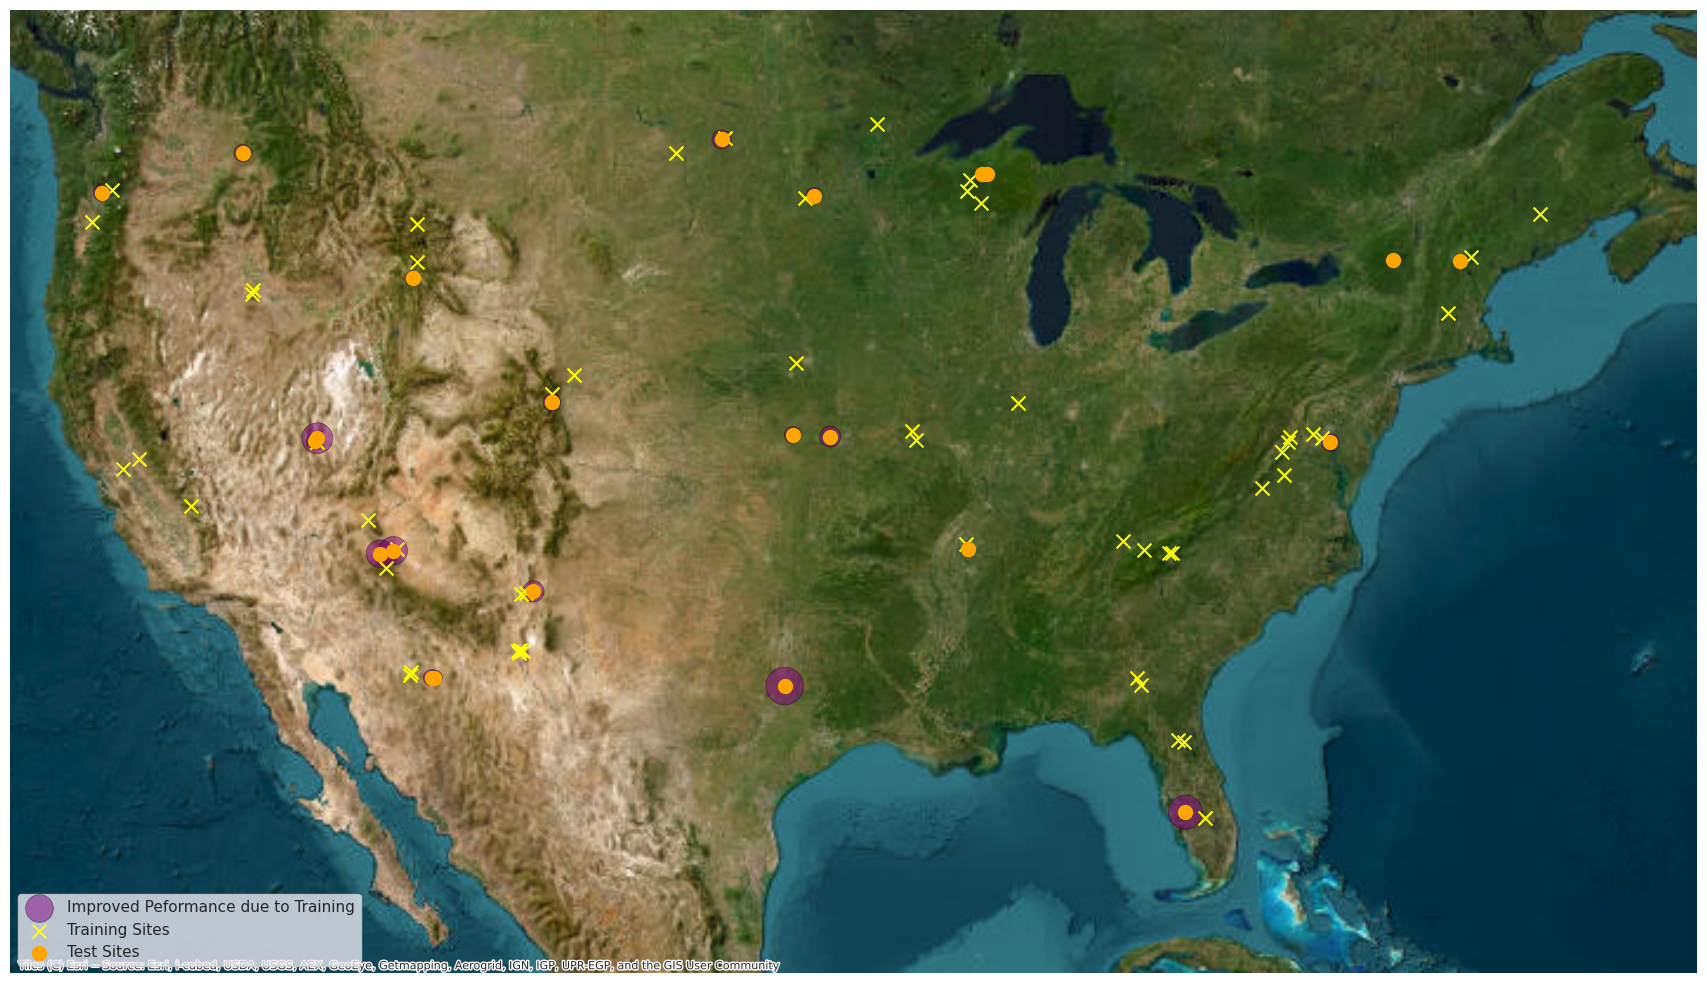

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx

# Load data
results_mae_map = results_mae.copy()
geo_data = gpd.read_file("/projectnb/hlsfm/applications/lsp/ancillary/HP_LSP/geotiff_extents.geojson")
geo_data = geo_data.rename(columns={"Site_ID": "SiteID"})

train_df = pd.read_csv("/usr4/cs505/mqraitem/ivc-ml/geo/data/LSP_train_samples.csv")
train_df = train_df[train_df["version"] == "v1"]  # Filter out rows with NaN HLStile
train_df = train_df.rename(columns={"tile": "HLStile"})

test_df = pd.read_csv("/usr4/cs505/mqraitem/ivc-ml/geo/data/LSP_test_samples.csv")
test_df = test_df[test_df["version"] == "v1"]  # Filter out rows with NaN HLStile
test_df = test_df.rename(columns={"tile": "HLStile"})

# Prepare HLStile names for joining
geo_data["HLStile"] = "T" + geo_data["name"]
geo_data = geo_data.set_crs("EPSG:4326").to_crs(epsg=3857)
geo_data["centroid"] = geo_data.geometry.centroid

# === RED CIRCLES: Where Pretraining Improves ===

# Compute average MAE per (HLStile, SiteID, Method)
methods = ["Transformer-LSP (LSP Data)", "Prithvi-Pretraining (Our Data)"]
mae_filtered = results_mae_map[results_mae_map["Method"].isin(methods)]

mae_summary = (
    mae_filtered.groupby(["HLStile", "SiteID", "Method"])["MAE"]
    .mean()
    .unstack()
    .dropna()
)

mae_summary["MAE_diff"] =  mae_summary["Prithvi-Pretraining (Our Data)"] - mae_summary["Transformer-LSP (LSP Data)"] 
mae_summary = mae_summary[mae_summary["MAE_diff"] > 0].reset_index()

# Join with tile centroids
mae_summary = mae_summary.merge(geo_data[["HLStile", "SiteID", "centroid"]], on=["HLStile", "SiteID"], how="left")
gdf_improve = gpd.GeoDataFrame(mae_summary, geometry="centroid", crs=geo_data.crs)

# === YELLOW Xs: Training tile-site pairs ===
train_pairs = train_df[["HLStile", "SiteID"]].drop_duplicates()
train_pairs = train_pairs.merge(
    geo_data[["HLStile", "SiteID", "centroid"]],
    on=["HLStile", "SiteID"],
    how="left"
)
gdf_train = gpd.GeoDataFrame(train_pairs, geometry="centroid", crs=geo_data.crs)

test_pairs = test_df[["HLStile", "SiteID"]].drop_duplicates()
test_pairs = test_pairs.merge(
    geo_data[["HLStile", "SiteID", "centroid"]],
    on=["HLStile", "SiteID"],
    how="left"
)

gdf_test = gpd.GeoDataFrame(test_pairs, geometry="centroid", crs=geo_data.crs)

# === Plot ===
fig, ax = plt.subplots(figsize=(18, 10))

# Basemap

# Red circles (improvements)
gdf_improve.plot(
    ax=ax,
    markersize=gdf_improve["MAE_diff"] *60,
    alpha=0.5,
    color="purple",
    edgecolor="black",
    linewidth=0.5,
    zorder=3,
    label="Improved Peformance due to Training"
)

# Yellow Xs (training tiles)
gdf_train.plot(
    ax=ax,
    color="yellow",
    marker="x",
    markersize=100,
    label="Training Sites",
    zorder=3
)

gdf_test.plot(
    ax=ax,
    color="orange",
    marker="o",
    markersize=100,
    label="Test Sites",
    zorder=3
)

cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery)
ax.set_xlim(-14000000, -7000000)
ax.set_ylim(2500000, 6500000)


ax.axis('off')
ax.legend(loc="lower left")

plt.tight_layout()
plt.show()


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Mapping from state abbreviations to full names (matching the GeoJSON)
state_abbrev = {
    'AL':'Alabama','AK':'Alaska','AZ':'Arizona','AR':'Arkansas','CA':'California','CO':'Colorado',
    'CT':'Connecticut','DE':'Delaware','FL':'Florida','GA':'Georgia','HI':'Hawaii','ID':'Idaho',
    'IL':'Illinois','IN':'Indiana','IA':'Iowa','KS':'Kansas','KY':'Kentucky','LA':'Louisiana',
    'ME':'Maine','MD':'Maryland','MA':'Massachusetts','MI':'Michigan','MN':'Minnesota',
    'MS':'Mississippi','MO':'Missouri','MT':'Montana','NE':'Nebraska','NV':'Nevada',
    'NH':'New Hampshire','NJ':'New Jersey','NM':'New Mexico','NY':'New York','NC':'North Carolina',
    'ND':'North Dakota','OH':'Ohio','OK':'Oklahoma','OR':'Oregon','PA':'Pennsylvania',
    'RI':'Rhode Island','SC':'South Carolina','SD':'South Dakota','TN':'Tennessee','TX':'Texas',
    'UT':'Utah','VT':'Vermont','VA':'Virginia','WA':'Washington','WV':'West Virginia',
    'WI':'Wisconsin','WY':'Wyoming'
}

def plot_state_points(state_list):
    # Strip numbers and deduplicate
    abbrevs = set(s.split('-')[0] for s in state_list)
    full_names = [state_abbrev[a] for a in abbrevs if a in state_abbrev]

    # Load a reliable GeoJSON of US states
    url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
    states = gpd.read_file(url)

    # Filter selected states
    selected = states[states['name'].isin(full_names)]

    # Plot US outline
    fig, ax = plt.subplots(figsize=(12,8))
    states.boundary.plot(ax=ax, linewidth=0.5, color="gray")
    selected.plot(ax=ax, color="lightblue", edgecolor="black")

    # Compute and plot centroids
    centroids = selected.geometry.centroid
    plt.scatter(centroids.x, centroids.y, color="red", zorder=5)

    # Label each state
    for name, (x,y) in zip(selected['name'], zip(centroids.x, centroids.y)):
        plt.text(x, y, name, fontsize=8, ha='center')

    plt.title("US States with Points at Centroids")
    plt.show()

/scratch/ipykernel_2805035/51601335.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = selected.geometry.centroid


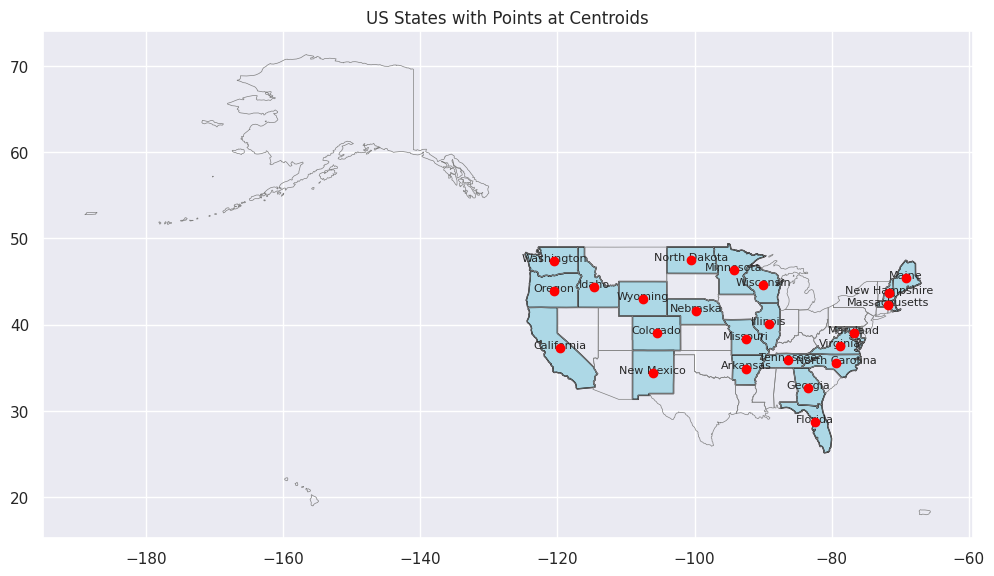

In [ ]:
samples_states = open("states_1.0_training.txt", "r").read().splitlines()
plot_state_points(samples_states)


/scratch/ipykernel_405728/51601335.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = selected.geometry.centroid


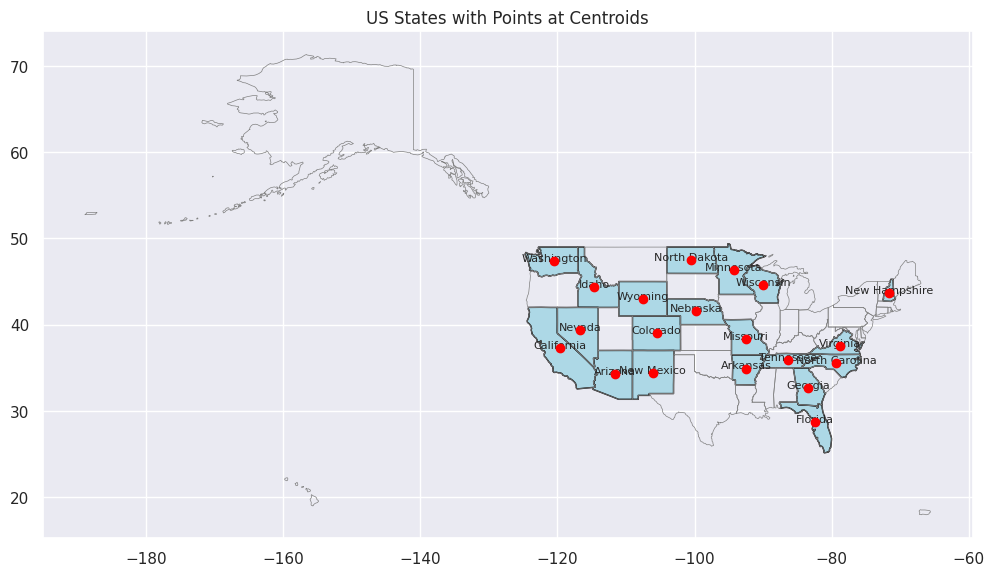

In [ ]:
samples_states = open("states_0.6.txt", "r").read().splitlines()
plot_state_points(samples_states)


/scratch/ipykernel_405728/51601335.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = selected.geometry.centroid


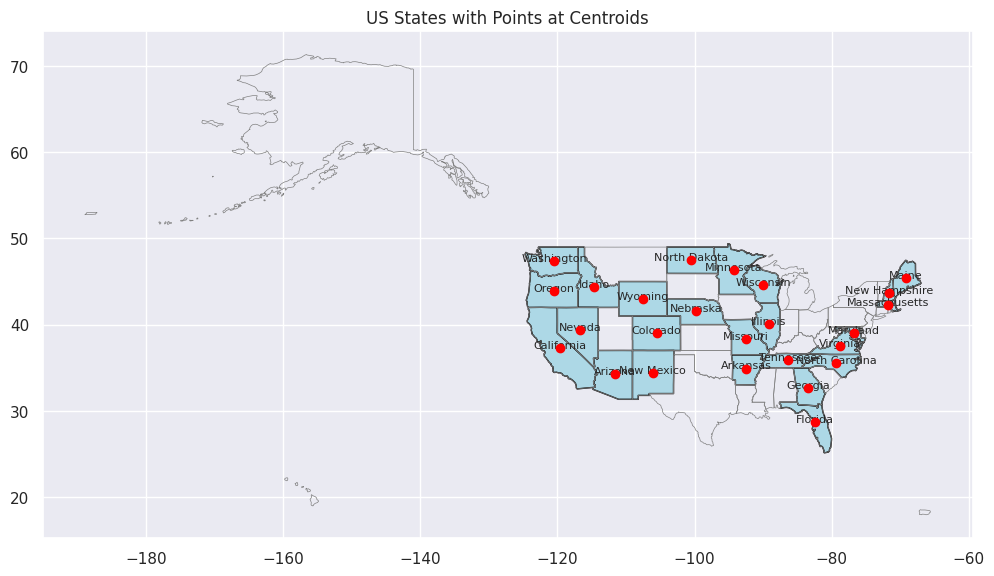

In [ ]:
samples_states = open("states_0.95.txt", "r").read().splitlines()
plot_state_points(samples_states)

In [4]:
def get_mae(df, tile, siteid, results, method):
    df_tile = df[(df["HLStile"] == tile) & (df["SiteID"] == siteid)]
    for date in ["G", "M", "S", "D"]: 
        mae = np.mean(np.abs(df_tile[f"{date}_pred_DOY"] - df_tile[f"{date}_truth_DOY"]))
        results["HLStile"].append(tile)
        results["Date"].append(date)
        results["MAE"].append(mae)
        results["SiteID"].append(siteid)
        results["Method"].append(method)
    return results 

results = {"HLStile": [], "Date": [], "MAE": [], "Method": [], "SiteID": []}

#unique combos of HLStile and SiteID
for tile, siteid in all_methods_final_val["Prithvi-Pretraining (Our Data),0.2,all"][["HLStile", "SiteID"]].drop_duplicates().values:
    for key in all_methods_final_val.keys(): 
        results = get_mae(all_methods_final_val[key], tile, siteid, results, key)


results_df = pd.DataFrame(results)
mean_results = results_df.groupby(["HLStile", "SiteID", "Method"]).agg({"MAE": "mean"}).reset_index()
mean_results["Date"] = "Mean"
results_mae_val = pd.concat([results_df, mean_results], ignore_index=True)

In [12]:
methods = [] 

def print_avg_results(methods):
    avg_results = {
        "Method": [],
        "Acc": [], 
        "Percent": []
    }
    for method in methods:
        print(f"Average MAE for {method}:")
        for date in ["G", "M", "S", "D"]:
            avg_mae = results_mae_val[(results_mae_val["Method"] == method) & (results_mae_val["Date"] == date)]["MAE"].mean()
            print(f"  {date}: {avg_mae:.1f}")
        overall_avg = results_mae_val[results_mae_val["Method"] == method]["MAE"].mean()
        print(f"  Overall: {overall_avg:.1f}\n")
        print("" + "="*40 + "\n")
        
        split_method = method.split(",") 
        if len(split_method) > 1: 
            percent = split_method[1]
        else: 
            percent = 1.0
        avg_results["Method"].append(split_method[0])
        avg_results["Acc"].append(float(overall_avg))
        avg_results["Percent"].append(float(percent))

    return avg_results

methods_to_print = [method for method in all_methods_final_val.keys() if "0.8" in method]
avg_results = print_avg_results(methods_to_print)




Average MAE for 1D Shallow Transformer (Our Data),0.8,all:
  G: 10.9
  M: 12.2
  S: 19.4
  D: 14.2
  Overall: 14.2


Average MAE for Prithvi-Pretraining (Our Data),0.8,all:
  G: 12.9
  M: 15.1
  S: 21.1
  D: 21.0
  Overall: 17.5


Average MAE for 1D Shallow QTransformer (Our Data),0.8,all:
  G: 10.1
  M: 11.4
  S: 19.5
  D: 13.6
  Overall: 13.7




In [ ]:
def ensemble_two(df1, df2):
    df_ens = df1.copy()
    pred_cols = [c for c in df1.columns if '_pred_' in c]
    for col in pred_cols:
        df_ens[col] = (df1[col] + df2[col]) / 2
    return df_ens


for data_percentage in [0.05, 0.2, 0.4, 0.6, 0.8, 1.0]: 
    for region in ["all"]: 
        method_1 = f"Prithvi-Pretraining (Our Data),{data_percentage},{region}"
        method_2 = f"1D Shallow Transformer (Our Data),{data_percentage},{region}"

        ensemble_df = ensemble_two(all_methods_final[method_1], all_methods_final[method_2])
        all_methods_final[f"Ensemble {method_1} + {method_2}"] = ensemble_df


In [ ]:
import numpy as np
import pandas as pd

def _opt_weight(x1, x2, y):
    """Closed-form least-squares weight for df1 (clamped to [0,1])."""
    a = x1 - x2
    b = y - x2
    denom = np.dot(a, a)
    if denom == 0 or np.isnan(denom):
        return 0.5
    w = float(np.dot(a, b) / denom)
    return max(0.0, min(1.0, w))

def _pred_cols(df):
    return [c for c in df.columns if '_pred_' in c]

def _global_weights(df1_val, df2_val):
    """Fallback weights (no region filtering)."""
    w = {}
    for col in _pred_cols(df1_val):
        truth_col = col.replace('_pred_', '_truth_')
        if truth_col not in df1_val.columns:
            w[col] = 0.5
            continue
        x1 = df1_val[col].to_numpy(float)
        x2 = df2_val[col].to_numpy(float)
        y  = df1_val[truth_col].to_numpy(float)
        w[col] = _opt_weight(x1, x2, y)
    return w

def learn_weights_two_by_region(df1_val: pd.DataFrame,
                                df2_val: pd.DataFrame,
                                region_col: str = 'NA_L1NAME') -> dict:
    """
    Returns: {region: {pred_col: w_for_df1}}, where w_for_df2 = 1 - w_for_df1.
    Falls back to global weights (or 0.5) when a region has no data / degenerate variance.
    """
    weights_by_region = {}
    pred_cols = _pred_cols(df1_val)
    global_w = _global_weights(df1_val, df2_val)

    # union of regions present in either df
    regions = set(df1_val[region_col].dropna().unique()) | set(df2_val[region_col].dropna().unique())

    for r in regions:
        mask1 = (df1_val[region_col] == r)
        mask2 = (df2_val[region_col] == r)
        mask = mask1 & mask2
        if mask.sum() == 0:
            # no rows for this region in val → use global
            weights_by_region[r] = dict(global_w)
            continue

        w_r = {}
        for col in pred_cols:
            truth_col = col.replace('_pred_', '_truth_')
            if truth_col not in df1_val.columns:
                w_r[col] = global_w.get(col, 0.5)
                continue

            x1 = df1_val.loc[mask, col].to_numpy(float)
            x2 = df2_val.loc[mask, col].to_numpy(float)
            y  = df1_val.loc[mask, truth_col].to_numpy(float)

            w_col = _opt_weight(x1, x2, y)
            # if degenerate, fall back to global
            if np.isnan(w_col):
                w_col = global_w.get(col, 0.5)
            w_r[col] = w_col
        weights_by_region[r] = w_r

    # also include a "__DEFAULT__" entry as a final fallback
    weights_by_region["__DEFAULT__"] = global_w
    return weights_by_region

def ensemble_two_weighted_by_region(df1: pd.DataFrame,
                                    df2: pd.DataFrame,
                                    weights_by_region: dict,
                                    region_col: str = 'NA_L1NAME') -> pd.DataFrame:
    """
    Applies region-specific weights row-wise; keeps original *_pred_* column names.
    """
    df_out = df1.copy()
    pred_cols = _pred_cols(df1)
    default_w = weights_by_region.get("__DEFAULT__", {c: 0.5 for c in pred_cols})

    # vectorized by region
    for r in df1[region_col].dropna().unique():
        mask1 = (df1[region_col] == r)
        mask2 = (df2[region_col] == r)
        mask = mask1 & mask2
        if mask.sum() == 0:
            continue

        wts = weights_by_region.get(r, default_w)
        for col in pred_cols:
            w = wts.get(col, default_w.get(col, 0.5))
            df_out.loc[mask, col] = w * df1.loc[mask, col] + (1 - w) * df2.loc[mask, col]

    # rows with NaN region or unmatched region fall back to default weights
    unmatched_mask = ~df1[region_col].isin(weights_by_region.keys()) | df1[region_col].isna()
    if unmatched_mask.any():
        for col in pred_cols:
            w = default_w.get(col, 0.5)
            df_out.loc[unmatched_mask, col] = w * df1.loc[unmatched_mask, col] + (1 - w) * df2.loc[unmatched_mask, col]

    return df_out

# ===== Learn on VAL (by region) then apply to TEST across your grid =====
for data_percentage in [1.0]:
    for region in ["all"]:
        method_1 = f"Prithvi-Pretraining (Our Data),{data_percentage},{region}"
        method_2 = f"1D Shallow Transformer (Our Data),{data_percentage},{region}"

        # 1) learn region-wise weights on validation
        wts_by_region = learn_weights_two_by_region(
            all_methods_final_val[method_1],
            all_methods_final_val[method_2],
            region_col='NA_L1NAME'
        )

        # 2) apply to test, keeping original pred column names
        ensemble_df_w = ensemble_two_weighted_by_region(
            all_methods_final[method_1],
            all_methods_final[method_2],
            wts_by_region,
            region_col='NA_L1NAME'
        )

        # 3) store with requested name
        all_methods_final[f"Ensemble Weighted Region {method_1} + {method_2}"] = ensemble_df_w
